In [144]:
from __future__ import division

import os

import numpy as np
import cv2

from os import listdir

import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, Flatten, Dropout, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import image_dataset_from_directory
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K

from keras.applications import EfficientNetB2

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration
width = 128
height = 128
depth = 3
batch_size = 32
default_image_size = tuple((height, width, depth))
# image_size = 0


root_dir_tf = 'F:\Coding\leaf_disease_detection\data'

### Load data using a Keras utility

In [80]:
try:
    root_dir_list = listdir(root_dir_tf)
    for sub_folder in root_dir_list:
        if sub_folder == 'train':
            train_ds = image_dataset_from_directory(
                directory=(f"{root_dir_tf}/{sub_folder}/"),
                labels='inferred',
                label_mode='int',
                batch_size=batch_size,
                 image_size=(height, width),
                 validation_split = 0.9,
                 subset= 'training',
                 seed=41
                 )


        elif sub_folder == 'valid':
            val_ds = image_dataset_from_directory(
                directory=(f"{root_dir_tf}/{sub_folder}/"),
                labels='inferred',
                label_mode='int',
                batch_size=batch_size,
                image_size=(height, width),
                validation_split = 0.9 ,
                subset= 'training',
                seed=41,
            )
        
        else:
            pass

except Exception as e:
    print(f"Error: {e}")


Found 70295 files belonging to 38 classes.
Using 7030 files for training.
Found 17572 files belonging to 38 classes.
Using 1758 files for training.


### Visualize the data

In [82]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

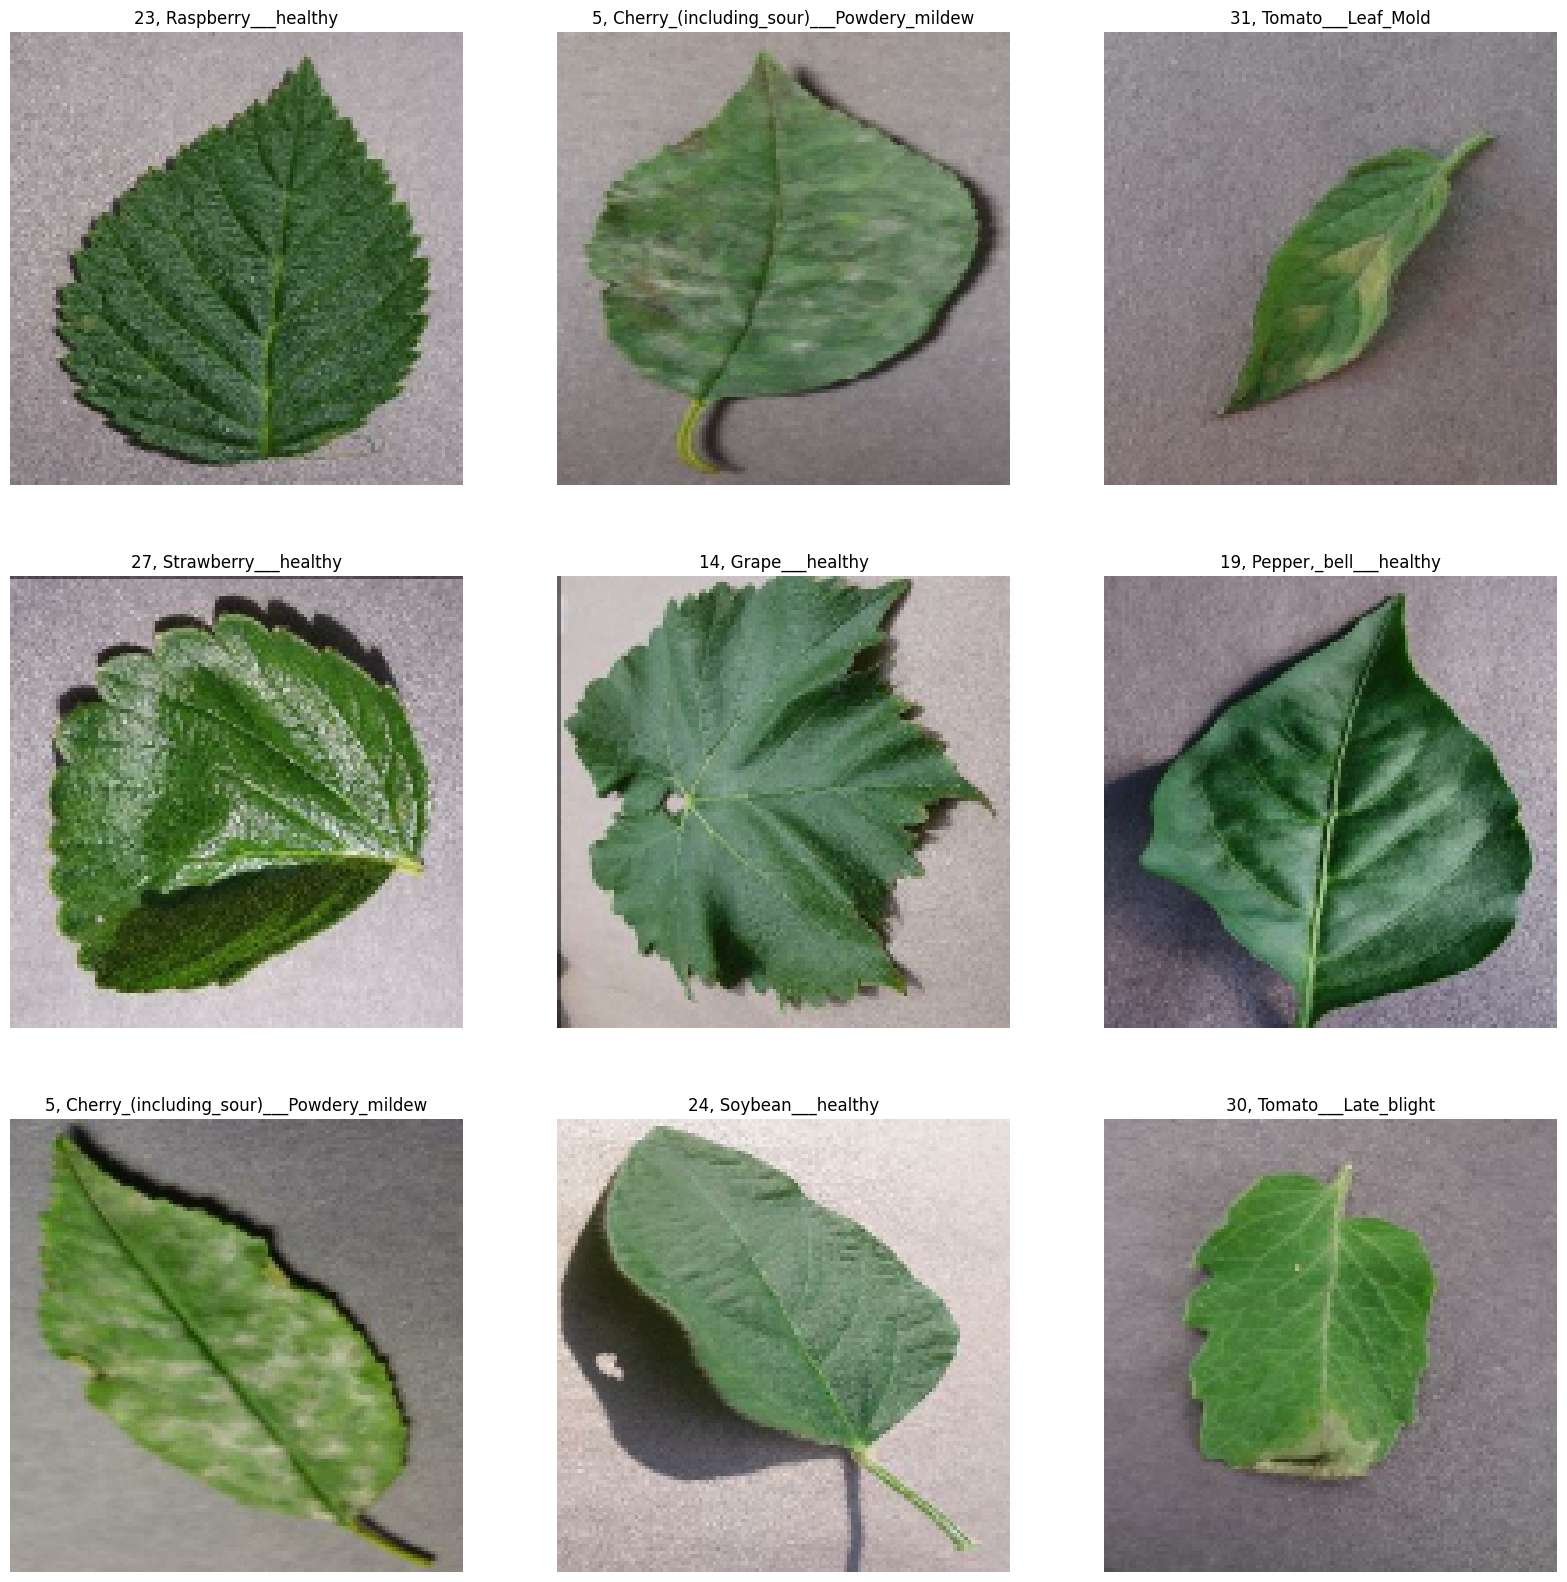

In [5]:
def plot_sample(pl_dataset , num_batch):
    plt.figure(figsize=(20, 20))
    for images, labels in pl_dataset.take(num_batch):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(int(labels[i])) + ', ' + class_names[labels[i]])
            plt.axis("off")

plot_sample(train_ds, 1)

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 128, 128, 3)
(32,)


### Data normalization

In [7]:
def scale(images, label):
    return images/255.0, label

train_ds = train_ds.map(scale)
val_ds = val_ds.map(scale)

### Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model

In [9]:
inputShape = (None, height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (None, depth, height, width)
    chanDim = 1
    
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=chanDim),
    MaxPooling2D((3, 3)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=chanDim),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=chanDim),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),

    # Conv2D(128, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(axis=chanDim),
    # MaxPooling2D((2, 2)),
    # Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.build(input_shape=inputShape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,612,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,675,174 (14.02 MB)

 Trainable params: 3,674,598 (14.02 MB)

 Non-trainable params: 576 (2.25 KB)

In [10]:
# Hyperparameters
init_lr= 1e-3
epochs = 30
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

opt = keras.optimizers.Adam(learning_rate=init_lr, )


In [11]:
model.compile(loss=loss_fn,
              optimizer=opt,
              metrics=["accuracy"])

### Fit the model

In [12]:
history = model.fit(
  x = train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  # callbacks=my_callbacks,
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.2776 - loss: 2.8026 - val_accuracy: 0.0216 - val_loss: 7.6108
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - accuracy: 0.6003 - loss: 1.4202 - val_accuracy: 0.2014 - val_loss: 3.3978
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - accuracy: 0.7308 - loss: 0.9488 - val_accuracy: 0.7093 - val_loss: 1.0921
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.8123 - loss: 0.6670 - val_accuracy: 0.7617 - val_loss: 0.9364
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.8681 - loss: 0.4770 - val_accuracy: 0.5939 - val_loss: 1.4289
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9034 - loss: 0.3431 - val_accuracy: 0.7964 - val_loss: 0.6171
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.9382 - loss: 0.2344 - val_accuracy: 0.7486 - val_loss: 0.7968
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.9293 - loss: 0

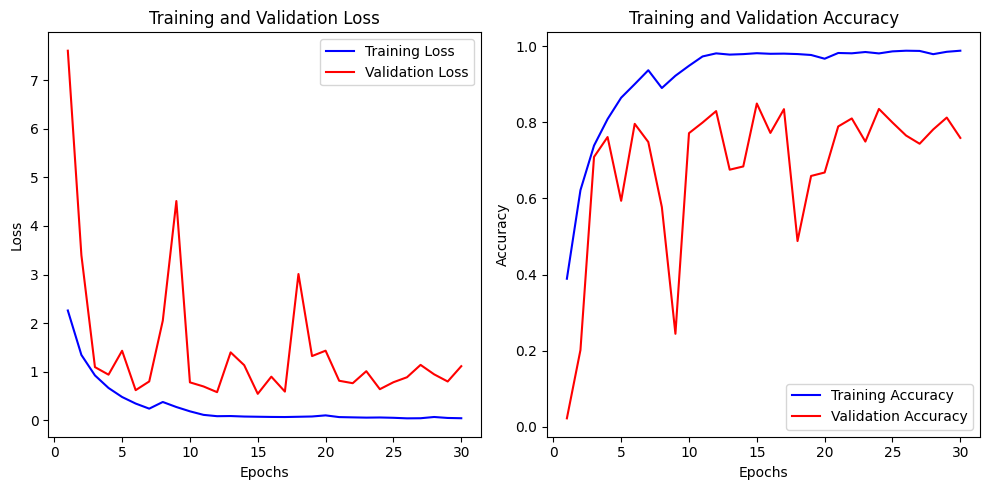

In [13]:
def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_and_accuracy(history)

In [154]:
for sub_folder in root_dir_list:
    if sub_folder == 'test':
        path = os.path.join(root_dir_tf, sub_folder, sub_folder)
        test_ds = tf.data.Dataset.list_files(path + '/*', shuffle=False)


# print(test_ds)

In [155]:
def get_label(img_path):
    label = tf.strings.split(img_path, os.path.sep)[-1]
    return label

def process_img(img_path):
    label = get_label(img_path)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [height,width])
    return img, label

In [156]:
mapped_test_ds = test_ds.map(process_img)
mapped_test_ds = mapped_test_ds.batch(batch_size)

In [157]:
model.predict(mapped_test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)